In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import os

from utils import *

In [2]:
CONFIG_TRAIN = {
    "antenna_config": "siso",  # Antenna configuration
    "channel_model": "rayleigh",  # Channel type
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 12,  # Training SNR (dB)
}
CONFIG_TRAIN["best_encoder_path"] = (
    f"./model/encoder_{CONFIG_TRAIN['antenna_config']}_{CONFIG_TRAIN['channel_model']}_{CONFIG_TRAIN['M']}qam_best_encoder.pt"
)
CONFIG_TRAIN["best_decoder_path"] = (
    f"./model/decoder_{CONFIG_TRAIN['antenna_config']}_{CONFIG_TRAIN['channel_model']}_{CONFIG_TRAIN['M']}qam_best_decoder.pt"
)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
encoder = Encoder([CONFIG_TRAIN["M"], 16, 16, 2]).to(device)
decoder = Decoder([2, 256, 256, CONFIG_TRAIN["M"]]).to(device)

In [4]:
def save_decoder(decoder, optimizer, loss):
    """
    Save the model to a file.
    - model_state_dict: the model state dictionary
    - optimizer_state_dict: the optimizer state dictionary
    - loss: the loss history
    """
    torch.save(
        {
            "model_state_dict": decoder.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        CONFIG_TRAIN["best_decoder_path"],
    )


def save_encoder(encoder, optimizer, loss):
    """
    Save the model to a file.
    - model_state_dict: the model state dictionary
    - optimizer_state_dict: the optimizer state dictionary
    - loss: the loss history
    """
    torch.save(
        {
            "model_state_dict": encoder.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss,
        },
        CONFIG_TRAIN["best_encoder_path"],
    )


def train_decoder(
    decoder, optimizer, max_iterations, loss_hist, batch_size, messages, rx
):
    criterion = nn.NLLLoss()  # negative log likelihood loss
    best_loss = float("inf")  # Initialize the best loss to infinity
    try:
        for iterator in tqdm(
            range(len(loss_hist), max_iterations), desc="training process"
        ):
            start_index = int(iterator * batch_size)
            end_index = int((iterator + 1) * batch_size - 1)
            messages_batch = messages[start_index:end_index]
            rx_batch = rx[iterator * batch_size : (iterator + 1) * batch_size - 1]
            y_pred = decoder(rx_batch)
            loss = criterion(y_pred, messages_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                save_decoder(decoder, optimizer, loss_hist)

        print("Training complete")

    except KeyboardInterrupt:
        save_decoder(decoder, optimizer, loss_hist)
        print("Training interrupted")

    save_decoder(decoder, optimizer, loss_hist)
    # Plot the loss
    plt.semilogy(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

# Train or load the model

Training from scratch


/var/folders/x4/5z4_pt2n7m12cdcvjm0d6cjw0000gn/T/ipykernel_18980/1263658573.py:35: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  rx = torch.from_numpy(rx).to(device)
training process: 100%|██████████| 1000/1000 [00:24<00:00, 41.66it/s]


Training complete


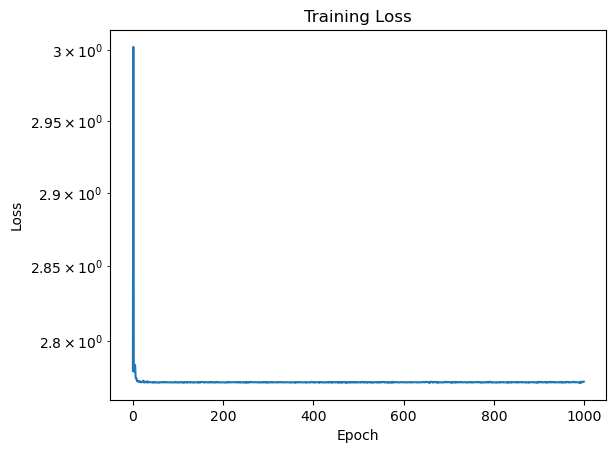

In [5]:
if CONFIG_TRAIN["flag_train_model"]:
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        # load the model, optimizer a loss history
        decoder.load_state_dict(checkpoint["Decoder"])

    parameters = list(decoder.parameters())
    optimizer = Adam(parameters, lr=0.01)

    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        # optimizer.load_state_dict(checkpoint["optimizer"])
        loss_hist = checkpoint["loss"]
        print(f"Resuming training from iterator {len(loss_hist)}")
    else:
        loss_hist = []
        print("Training from scratch")

    max_iterations = int(1e3)  # Total number of epochs to train
    batch_size = int(1e4)  # Number of messages to use for training (batch size)
    if max_iterations > len(loss_hist):
        num_messages = (max_iterations - len(loss_hist)) * batch_size
        messages = torch.randint(0, 16, size=(num_messages + 8,), device=device)
        one_hot = F.one_hot(messages, 16).float()
        tx = encoder(one_hot)
        # write tx to a binary file
        tx = tx.detach().numpy()
        with open("./file/tx.dat", "wb") as f:
            f.write(tx.tobytes())
        # run channel.py to generate rx
        # os.system("python3 ./gnuradio/fading_awgn_model.py")
        # read rx from a binary file
        with open("./file/rx.dat", "rb") as f:
            rx = np.frombuffer(f.read(), dtype=np.float32)
        rx = torch.from_numpy(rx).to(device)
        rx = rx.view(-1, 2)
        messages = messages[3:-5]
        train_decoder(
            decoder, optimizer, max_iterations, loss_hist, batch_size, messages, rx
        )
    else:
        print("epochs already completed")
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        decoder.load_state_dict(checkpoint["Decoder"])
        print("Model loaded. Training iterator: ", len(checkpoint["loss"]))
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

# Test the model

In [7]:
num_messages = int(1e4)
messages = torch.randint(0, 16, size=(num_messages + 8,), device=device)
one_hot = F.one_hot(messages, 16).float()
tx = encoder(one_hot)
# write tx to a binary file
tx = tx.detach().numpy()
with open("./file/tx.dat", "wb") as f:
    f.write(tx.tobytes())
# run channel.py to generate rx
os.system("python3 ./gnuradio/fading_awgn_model.py")
# read rx from a binary file
with open("./file/rx.dat", "rb") as f:
    rx = np.frombuffer(f.read(), dtype=np.float32)
rx = torch.from_numpy(rx).to(device)
rx = rx.view(-1, 2)
messages = messages[3:-5]

# load the best decoder
checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
decoder.load_state_dict(checkpoint["model_state_dict"])

# calculate the SER
y_pred = decoder(rx)
m_hat = torch.argmax(y_pred, -1)
err = torch.sum(torch.not_equal(messages, m_hat)).to("cpu").detach().numpy()
SER = err / len(messages)
print("SER: ", SER)

SER:  0.9359
